In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use("default")


In [6]:
DATA_PATH = "master_dataset.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (71996, 9)


,label,num_processes,cpu_percent,memory_percent,disk_percent,total_allocated,total_need,deadlock_risk,source
0,SAFE,15,15.4,59.1,9.7,173,258,0.0,real_collection
1,SAFE,15,7.7,59.5,9.7,174,251,0.0,real_collection
2,SAFE,15,3.6,59.1,9.7,171,252,0.0,real_collection
3,SAFE,15,4.4,58.5,9.7,172,234,0.0,real_collection
4,SAFE,15,6.7,58.7,9.7,169,259,0.0,real_collection


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71996 entries, 0 to 71995
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label            71996 non-null  object 
 1   num_processes    71996 non-null  int64  
 2   cpu_percent      71996 non-null  float64
 3   memory_percent   71996 non-null  float64
 4   disk_percent     71996 non-null  float64
 5   total_allocated  71996 non-null  int64  
 6   total_need       71996 non-null  int64  
 7   deadlock_risk    71996 non-null  float64
 8   source           71996 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 4.9+ MB


In [8]:
df["label"].value_counts()


label
SAFE        71631
UNSAFE        357
DEADLOCK        8
Name: count, dtype: int64

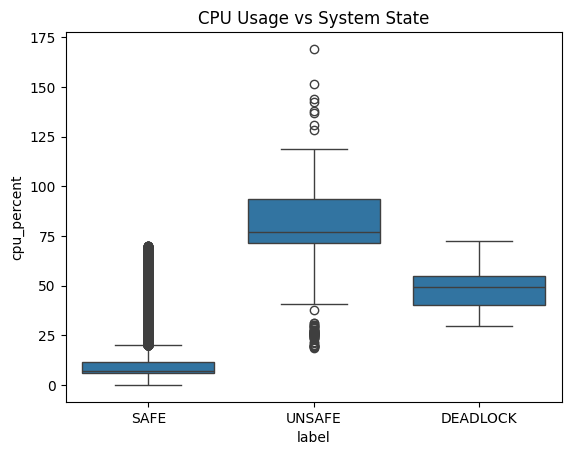

In [9]:
plt.figure()
sns.boxplot(x="label", y="cpu_percent", data=df)
plt.title("CPU Usage vs System State")
plt.savefig("cpu_vs_label.png")
plt.show()

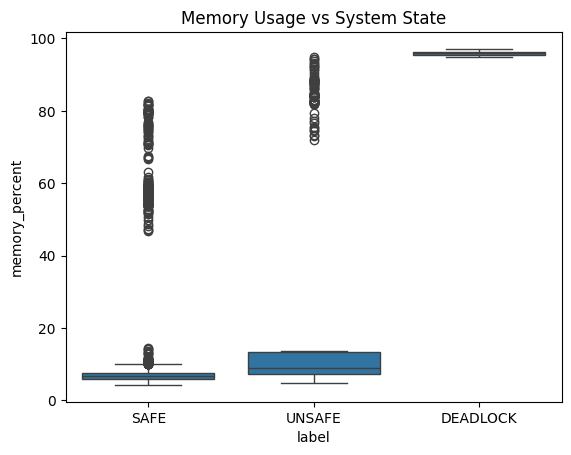

In [10]:
plt.figure()
sns.boxplot(x="label", y="memory_percent", data=df)
plt.title("Memory Usage vs System State")
plt.savefig("memory_vs_label.png")
plt.show()

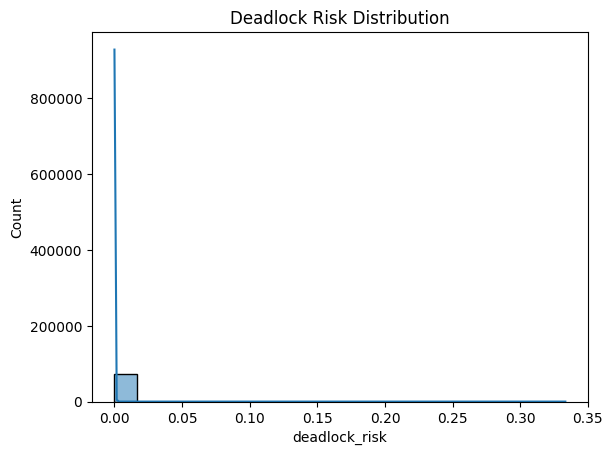

In [11]:
plt.figure()
sns.histplot(df["deadlock_risk"], bins=20, kde=True)
plt.title("Deadlock Risk Distribution")
plt.savefig("deadlock_risk_distribution.png")
plt.show()

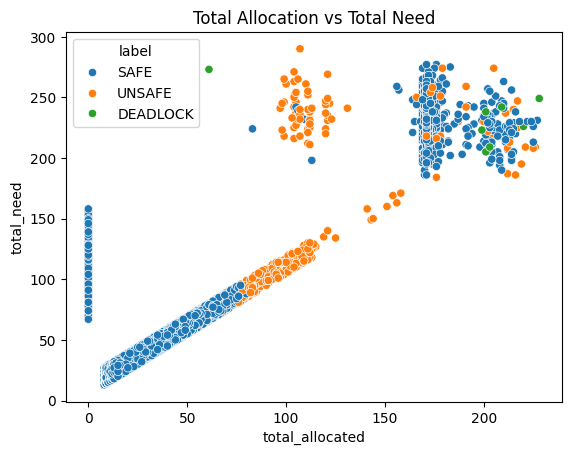

In [12]:
plt.figure()
sns.scatterplot(
    x="total_allocated",
    y="total_need",
    hue="label",
    data=df
)
plt.title("Total Allocation vs Total Need")
plt.savefig("allocation_vs_need.png")
plt.show()

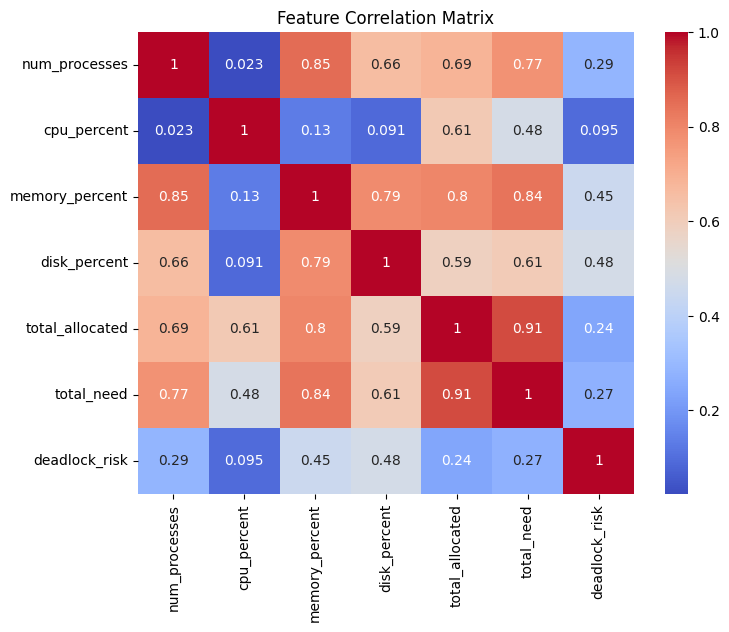

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [14]:
df = df.sort_index()

numeric_cols = df.select_dtypes(np.number).columns

for col in numeric_cols:
    df[f"{col}_mean"] = df[col].rolling(window=5).mean()
    df[f"{col}_std"] = df[col].rolling(window=5).std()

df.dropna(inplace=True)

print("After temporal features:", df.shape)


After temporal features: (71992, 23)


In [15]:
label_map = {"DEADLOCK": 0, "SAFE": 1, "UNSAFE": 2}
df["label_encoded"] = df["label"].map(label_map)

X = df.drop(columns=["label", "label_encoded", "source"])
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [16]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [17]:
y_pred = model.predict(X_test)

print(classification_report(
    y_test, y_pred,
    target_names=label_map.keys()
))


              precision    recall  f1-score   support

    DEADLOCK       1.00      1.00      1.00         2
        SAFE       1.00      1.00      1.00     17907
      UNSAFE       1.00      0.98      0.99        89

    accuracy                           1.00     17998
   macro avg       1.00      0.99      1.00     17998
weighted avg       1.00      1.00      1.00     17998



In [18]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


total_allocated         0.169125
deadlock_risk           0.142497
total_need              0.114258
memory_percent          0.113712
total_allocated_std     0.068413
cpu_percent             0.057403
total_allocated_mean    0.048365
disk_percent_std        0.044729
deadlock_risk_std       0.039313
total_need_mean         0.036398
dtype: float64

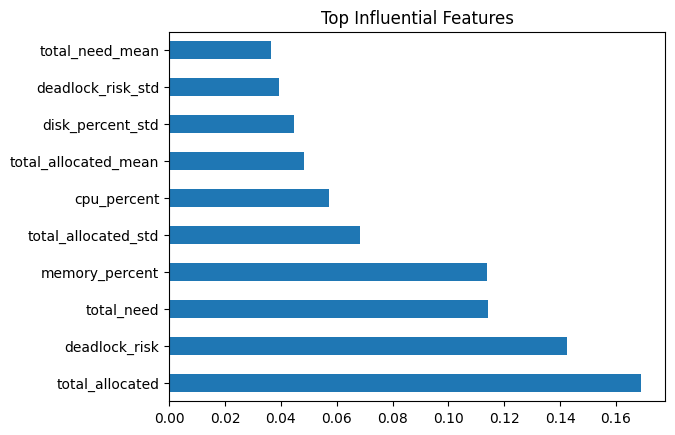

In [19]:
importances.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top Influential Features")
plt.show()


              precision    recall  f1-score   support

    DEADLOCK       1.00      1.00      1.00         2
        SAFE       1.00      1.00      1.00     17907
      UNSAFE       1.00      0.98      0.99        89

    accuracy                           1.00     17998
   macro avg       1.00      0.99      1.00     17998
weighted avg       1.00      1.00      1.00     17998



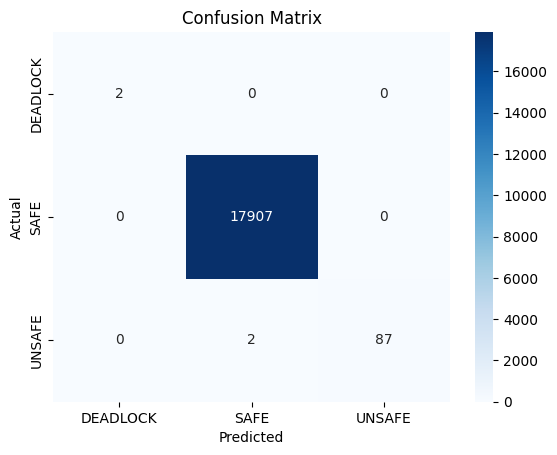

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


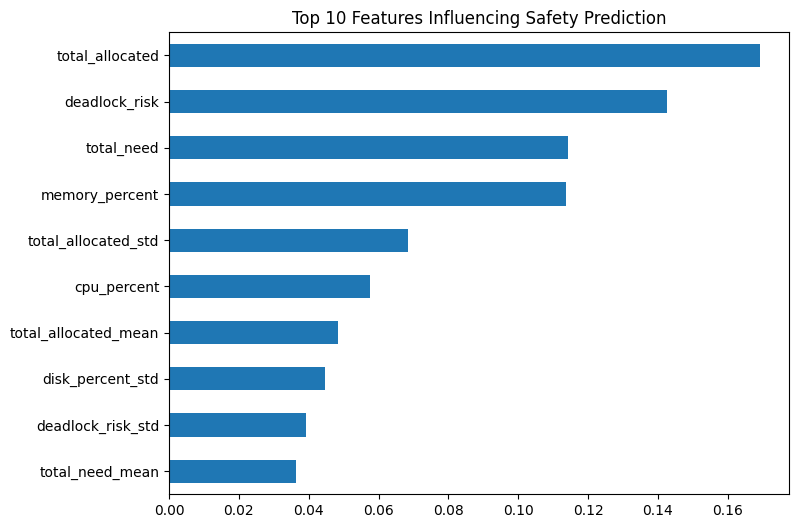

In [21]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(10).plot(kind="barh")
plt.title("Top 10 Features Influencing Safety Prediction")
plt.gca().invert_yaxis()
plt.show()


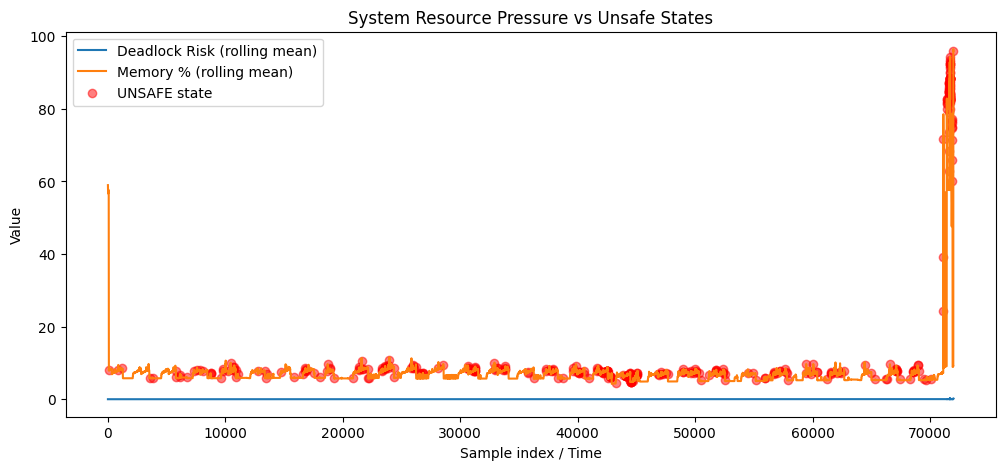

In [22]:
# Example: plot deadlock_risk and memory_percent over index
plt.figure(figsize=(12,5))
plt.plot(df.index, df["deadlock_risk_mean"], label="Deadlock Risk (rolling mean)")
plt.plot(df.index, df["memory_percent_mean"], label="Memory % (rolling mean)")
plt.scatter(df.index[df["label"]=="UNSAFE"], df["memory_percent_mean"][df["label"]=="UNSAFE"], color='red', label="UNSAFE state", alpha=0.5)
plt.xlabel("Sample index / Time")
plt.ylabel("Value")
plt.title("System Resource Pressure vs Unsafe States")
plt.legend()
plt.show()


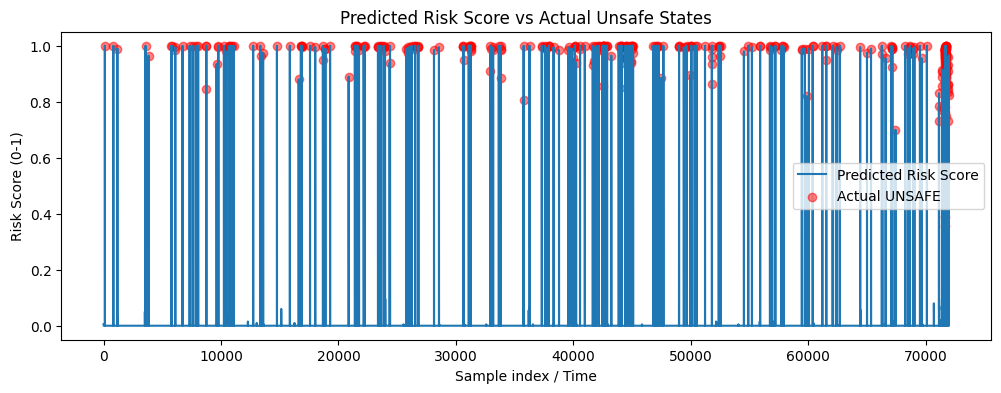

In [23]:
# Predict probabilities instead of labels
risk_probs = model.predict_proba(X)  # each column = SAFE / UNSAFE / DEADLOCK

# Add a “risk_score” = probability of being UNSAFE + DEADLOCK
df["risk_score"] = risk_probs[:, label_map["UNSAFE"]] + risk_probs[:, label_map["DEADLOCK"]]

# Plot risk_score over time
plt.figure(figsize=(12,4))
plt.plot(df.index, df["risk_score"], label="Predicted Risk Score")
plt.scatter(df.index[df["label"]=="UNSAFE"], df["risk_score"][df["label"]=="UNSAFE"], color='red', alpha=0.5, label="Actual UNSAFE")
plt.xlabel("Sample index / Time")
plt.ylabel("Risk Score (0-1)")
plt.title("Predicted Risk Score vs Actual Unsafe States")
plt.legend()
plt.show()


In [24]:
deadlock_test = df[df["label"]=="DEADLOCK"]

# Use the same feature columns as training
X_deadlock = deadlock_test[X.columns]  # X.columns = training feature names

print("Deadlock samples:", deadlock_test.shape[0])
print("Predicted:", model.predict(X_deadlock))


Deadlock samples: 8
Predicted: [0 0 0 0 0 0 0 0]


In [25]:
y_deadlock_proba = model.predict_proba(X_deadlock)
print("Predicted probabilities:\n", y_deadlock_proba)


Predicted probabilities:
 [[0.84       0.02000178 0.13999822]
 [0.84       0.035      0.125     ]
 [0.845      0.08500104 0.06999896]
 [0.82       0.115      0.065     ]
 [0.935      0.035      0.03      ]
 [0.94       0.04000104 0.01999896]
 [0.545      0.10505075 0.34994925]
 [0.81       0.155      0.035     ]]


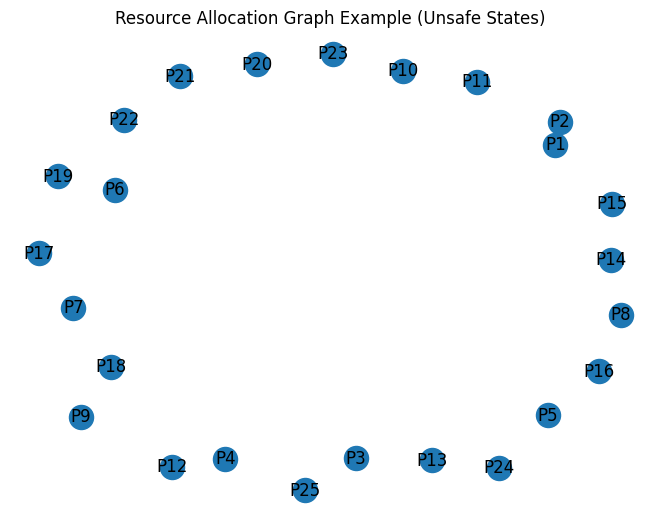

In [26]:
import networkx as nx

G = nx.Graph()

# Add processes as nodes
for i in range(df["num_processes"].max()):
    G.add_node(f"P{i+1}")

# Example: edges = allocation pressure
for i, row in df.iterrows():
    if row["label"]=="UNSAFE":
        G.add_edge(f"P1", f"P2", weight=row["deadlock_risk"])

nx.draw(G, with_labels=True)
plt.title("Resource Allocation Graph Example (Unsafe States)")
plt.show()


In [27]:
import joblib
joblib.dump(model, "rf_model.joblib")


['rf_model.joblib']

In [28]:
from sklearn.ensemble import RandomForestClassifier
import joblib

live_features = [
    "num_processes",
    "cpu_percent",
    "memory_percent",
    "disk_percent",
    "total_allocated",
    "total_need",
    "deadlock_risk"
]

X_live = df[live_features]
y_live = df["label_encoded"]

model_live = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42
)

model_live.fit(X_live, y_live)

joblib.dump(model_live, "rf_model_live.joblib")
print("Live inference model saved")


Live inference model saved


In [29]:
model = joblib.load("rf_model_live.joblib")


In [30]:
import psutil
import pandas as pd
import joblib

# 1. Load the trained live-inference model
model = joblib.load("rf_model_live.joblib")

# 2. Collect live system metrics
cpu = psutil.cpu_percent(interval=1)
memory = psutil.virtual_memory().percent
disk = psutil.disk_usage("/").percent
num_proc = len(psutil.pids())

# 3. Compute resource-allocation features
total_allocated = cpu + memory
total_need = max(0, 200 - total_allocated)
deadlock_risk = min(1.0, (cpu + memory) / 200)

# 4. Build input feature vector
X_live = pd.DataFrame([{
    "num_processes": num_proc,
    "cpu_percent": cpu,
    "memory_percent": memory,
    "disk_percent": disk,
    "total_allocated": total_allocated,
    "total_need": total_need,
    "deadlock_risk": deadlock_risk
}])

# 5. Perform inference
pred = model.predict(X_live)[0]

labels = {0: "HIGH-RISK(DEADLOCK-PRONE)", 1: "SAFE", 2: "UNSAFE"}

print("LIVE SYSTEM METRICS:")
display(X_live)

print("PREDICTED SYSTEM STATE:", labels[pred])


LIVE SYSTEM METRICS:


,num_processes,cpu_percent,memory_percent,disk_percent,total_allocated,total_need,deadlock_risk
0,304,55.0,79.9,54.5,134.9,65.1,0.6745


PREDICTED SYSTEM STATE: SAFE
